# Imports

In [2]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np

## Load data

In [4]:
df = pd.read_csv("e-commerce.csv")

In [7]:
df.dtypes

Unnamed: 0                         int64
order_id                          object
customer_id                       object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
order_item_id                      int64
product_id                        object
seller_id                         object
shipping_limit_date               object
price                            float64
freight_value                    float64
product_category_name             object
product_name_lenght              float64
product_description_lenght       float64
product_photos_qty               float64
product_weight_g                 float64
product_length_cm                float64
product_height_cm                float64
product_width_cm                 float64
seller_zip_code_prefix             int64
seller_city     

### Fix dtypes

In [11]:
#date_cols = [order_delivered_customer_date", "order_estimated_delivery_date", "order_purchase_timestamp", "order_delivered_customer_date"]

df["order_delivered_carrier_date"] = pd.to_datetime(df["order_delivered_carrier_date"])
df["order_estimated_delivery_date"] = pd.to_datetime(df["order_estimated_delivery_date"])
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
df["order_delivered_customer_date"] = pd.to_datetime(df["order_delivered_customer_date"])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['shipping_limit_date'] = pd.to_datetime(df['shipping_limit_date'])

df['expected_delivery_timedelta'] = pd.to_numeric(df['order_estimated_delivery_date']- df["order_purchase_timestamp"])
df['delivery_time'] = pd.to_numeric(df["order_delivered_customer_date"] - df['order_purchase_timestamp'])

df['product_volume'] = df["product_length_cm"] * df["product_height_cm"] * df["product_width_cm"]

df["same_city"] = df["customer_city"] == df["seller_city"]
df["same_state"] = df["customer_state"] == df["seller_state"]

In [12]:
df.dtypes

Unnamed: 0                                int64
order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
order_item_id                             int64
product_id                               object
seller_id                                object
shipping_limit_date              datetime64[ns]
price                                   float64
freight_value                           float64
product_category_name                    object
product_name_lenght                     float64
product_description_lenght              float64
product_photos_qty                      float64
product_weight_g                        float64
product_length_cm                       

# Data exploration

## **How many customers are there?**

In [20]:
df.customer_id.nunique()

98666

## **Whats the distribution on number of purchases per customer?**

In [24]:
cutomer_order_num = df.groupby("customer_id").order_item_id.count()

In [30]:
cutomer_order_num.value_counts()

1     88863
2      7516
3      1322
4       505
5       204
6       198
7        22
10        8
8         8
12        5
11        4
9         3
15        2
14        2
20        2
13        1
21        1
Name: order_item_id, dtype: int64

In [32]:
cutomer_order_num.value_counts() / np.sum(cutomer_order_num) * 100

1     78.884154
2      6.671993
3      1.173546
4      0.448291
5      0.181092
6      0.175766
7      0.019530
10     0.007102
8      0.007102
12     0.004439
11     0.003551
9      0.002663
15     0.001775
14     0.001775
20     0.001775
13     0.000888
21     0.000888
Name: order_item_id, dtype: float64

So 78% of customers only made one purchase. So 22% of people made two or more purchases.

## **Is there a month where theres more one-time purchases**?

In [51]:
df["month"] = df.order_purchase_timestamp.dt.month # Create month column
one_time_customers = df[df.customer_id.isin(cutomer_order_num[cutomer_order_num == 1].index.values)] # Select one-time customers

Text(0.5, 1.0, 'Number of one-time purchasers in a given month')

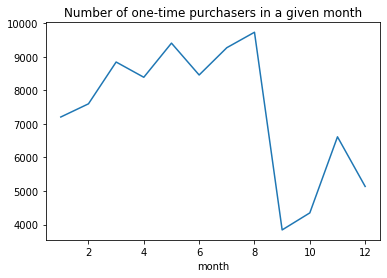

In [56]:
one_time_customers.groupby("month").count()["order_id"].plot()
plt.title("Number of one-time purchasers in a given month")

There is, **but is is due to less overall purchases?**

Text(0.5, 1.0, 'Number of purchases in a given month')

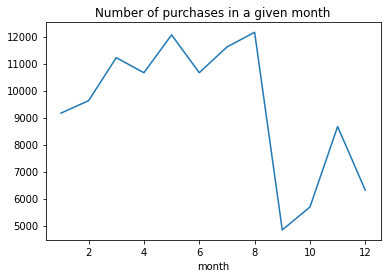

In [58]:
df.groupby("month").count()["order_id"].plot()
plt.title("Number of purchases in a given month")

Text(0.5, 1.0, 'Ratio between one-time purchases and overall purchases')

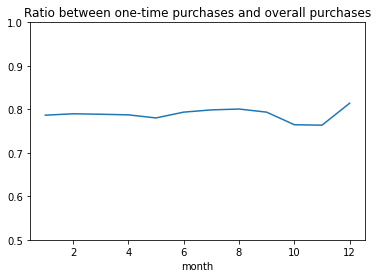

In [63]:
(one_time_customers.groupby("month").count()["order_id"] / df.groupby("month").count()["order_id"]).plot()
plt.ylim([0.5, 1])
plt.title("Ratio between one-time purchases and overall purchases")

We can see that this ratio increases a little bit in december, propably due to christmas.

## What customers get the most profit per order?

In [69]:
df["total_orders"] = df["customer_id"].map(df["customer_id"].value_counts())

In [71]:
df.groupby("total_orders").price.mean()

total_orders
1     130.378012
2      87.547858
3      79.194894
4      79.394262
5      76.700980
6      69.116936
7      69.676429
8     265.670000
9      86.833333
10    145.632000
11     71.328409
12     46.305000
13     29.990000
14     44.495000
15     58.245000
20     99.350000
21      1.514286
Name: price, dtype: float64

We can see that one-time customers spend more money per order.

**Average money spend on one order by one-time customer**

In [81]:
df[df["total_orders"] == 1].price.mean()

130.3780119959938

**Average money spend on one order by returning customer**

In [78]:
df[df["total_orders"] > 1].price.mean() # Average money spend on one order by returning customer

84.32599403035272

**Mean total money spend by returning customer**

In [83]:
df[df["total_orders"] > 1].groupby("customer_id").price.sum().mean() # Mean total money spend by returning customer

204.61720085688054

So even though, one-time customers spend more money per order. Returning customers spend more money overall.

## Does that mean that we can predict a returning customer by his first purchase?

In [90]:
first_purchase = df.sort_values("order_purchase_timestamp", ascending=True).groupby("customer_id").price.first()

In [114]:
df2 = pd.DataFrame(cutomer_order_num)
df2["first_purchase"] = df2.index.map(first_purchase)

In [115]:
df2.loc[df2.order_item_id ==1, "order_item_id"] = 0

In [116]:
df2.loc[df2.order_item_id > 1, "order_item_id"] = 1

In [117]:
df2.columns = ["is_returning_customer", "first_purchase"]

<AxesSubplot:xlabel='is_returning_customer', ylabel='first_purchase'>

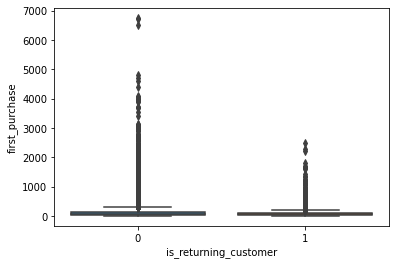

In [118]:
sns.boxplot(x="is_returning_customer", y="first_purchase",data=df2)

In [153]:
returning_customers = df2[df2["is_returning_customer"]==1]
returning_customers

Index(['00066ccbe787a588c52bd5ff404590e3', '000bf8121c3412d3057d32371c5d3395',
       '001450ebb4a77efb3d68be5f7887cb1e', '002f90a6eb386bc43bc9ba200db31a89',
       '0031abfb953b66e998f67b09e7b11375', '00331de1659c7f4fb660c8810e6de3f5',
       '003a75d228dc67cb2918e40c2aacc4bf', '00426311a53f3c052943c88b692a3be2',
       '004440537b68545ca3c341d7279bc4c0', '00474d2582fd72663036795b7ab8cfc1',
       ...
       'ffc436ef9df6ede268ee1548a0dfbbba', 'ffd094af4643c7ac712acd36a56feccc',
       'ffd294eea523f67ee8c743d3a904ee20', 'ffdaaad4323306777060ca43b3f87e7f',
       'ffde64401f7cb62d2e8696d9467c781d', 'ffe7ffb7c7ae0d42808f387578426b3b',
       'ffed5d4f6245fe13cd57054621eec36a', 'fff168ca1f8a1d2e8e2108b231a68a8c',
       'fff93c1da78dafaaa304ff032abc6205', 'ffffa3172527f765de70084a7e53aae8'],
      dtype='object', name='customer_id', length=9803)

In [159]:
df3 = pd.concat((returning_customers,df2[df2["is_returning_customer"]==0].sample(len(returning_customers))))

In [184]:
df3.head(3)

,is_returning_customer,first_purchase
customer_id,,
00066ccbe787a588c52bd5ff404590e3,1,49.90
000bf8121c3412d3057d32371c5d3395,1,15.00
001450ebb4a77efb3d68be5f7887cb1e,1,19.57


In [195]:
X = df3["first_purchase"].values.reshape(-1, 1)
y = df3["is_returning_customer"]

In [226]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0, max_depth=1, min_samples_leaf=4)

In [227]:
X.shape

(19606, 1)

In [228]:
y.value_counts()

1    9803
0    9803
Name: is_returning_customer, dtype: int64

In [229]:
cross_val_score(clf, X, y, cv=10)

array([0.55991841, 0.58286588, 0.56654768, 0.57521673, 0.57827639,
       0.56501785, 0.56071429, 0.57755102, 0.55765306, 0.57653061])

In [230]:
clf.fit(X, y)
y_pred = clf.predict(X)

In [245]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y, y_pred, target_names=["one-time", "returning"]))

              precision    recall  f1-score   support

    one-time       0.64      0.33      0.44      9803
   returning       0.55      0.81      0.65      9803

    accuracy                           0.57     19606
   macro avg       0.59      0.57      0.54     19606
weighted avg       0.59      0.57      0.54     19606



In [246]:
confusion_matrix(y, y_pred)

array([[3250, 6553],
       [1860, 7943]])

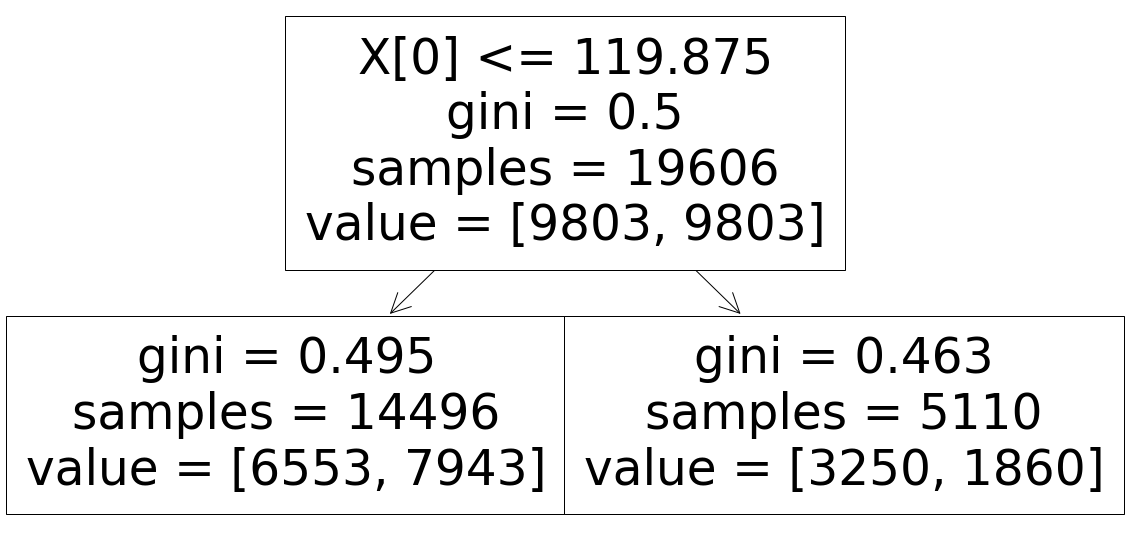

In [233]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(clf, max_depth=3)
plt.show()

In [250]:
print(confusion_matrix(df2.is_returning_customer.values, clf.predict(df2.first_purchase.values.reshape(-1, 1))))

[[29409 59454]
 [ 1860  7943]]
